In [1]:
import torch
from snn_delays.snn import SNN
from snn_delays.experimental_models.snn_binary import TH_BinarySNN, BinarySNN
from snn_delays.utils.dataset_loader import DatasetLoader
from snn_delays.utils.model_loader import ModelLoader
from snn_delays.utils.train_utils import train, get_device, propagate_batch
from snn_delays.utils.visualization_utils import plot_raster
from snn_delays.utils.test_behavior import tb_save_max_last_acc
import matplotlib.pyplot as plt

device = get_device()

# For reproducibility
torch.manual_seed(10)

c:\Users\Alberto\anaconda3\envs\deepsnn\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on: cuda:0


In [2]:
### DATASET

# Parameters
dataset = 'stmnist'
total_time = 50
batch_size = 1024

# Resized dataloader
# DATASET
DL = DatasetLoader(dataset=dataset,
                   caching='memory',
                   num_workers=0,
                   batch_size=batch_size,
                   total_time=total_time)

train_loader, test_loader, dataset_dict = DL.get_dataloaders()

[ToFrame(sensor_size=(10, 10, 2), time_window=None, event_count=None, n_time_bins=50, n_event_bins=None, overlap=0, include_incomplete=False)]


In [ ]:
snn_relu = ModelLoader('trainable_threshold_stmnist50_l1_1d1.t7_725179856115108_max_100epoch','exp_snn2chip', batch_size, device, True)
snn_relu.to(device)

# initial scores
a, b =snn_relu.test(test_loader)


[INFO] Delays: tensor([0])

[INFO] Delays i: tensor([0])

[INFO] Delays h: tensor([0])

[INFO] Delays o: tensor([0])
2000.0
Delta t: 40.0 ms
mean of normal: -1.8545865421311407
Instance of <class 'snn_delays.experimental_models.snn_binary.BinarySNN'> loaded successfully
Test Loss: 1.034411907196045
Avg spk_count per neuron for all 50 time-steps 18.14712142944336
Avg spk per neuron per layer [18.147122302158273]
Test Accuracy of the model on the test samples: 72.518



tensor(0.0152, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0614, device='cuda:0', grad_fn=<MeanBackward0>)


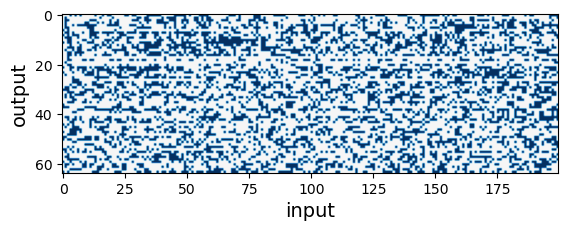

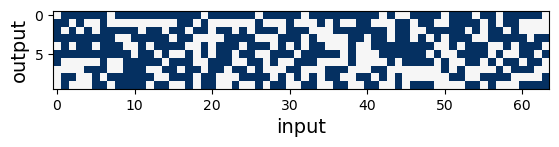

Test Loss: 2.3164952993392944
Avg spk_count per neuron for all 50 time-steps 2.3436038494110107
Avg spk per neuron per layer [2.343603866906475]
Test Accuracy of the model on the test samples: 14.388



In [8]:
from snn_delays.utils.visualization_utils import plot_param, plot_distributions

w_params = [w for name, w  in snn_relu.named_parameters() if 'f' in name]

for w in w_params:
    scale = w.abs().mean()
    print(scale)
    #w.data = (w.data > 0.0).float().mul(scale)
    w.data = w.data.sign().mul(scale)
    #w.data = w.data.div(scale).clamp(0, 1).mul(scale)

for w in w_params:
    plot_param(w, '2D')
    plt.show()

a, b =snn_relu.test(test_loader)


In [11]:
dataset_dict["time_ms"] = 2e3
snn = TH_BinarySNN(dataset_dict=dataset_dict, structure=snn_relu.structure, connection_type='f',
          delay=None, delay_type='', tau_m='normal', binary_mode='binary',
          reset_to_zero=True, win=total_time,
          loss_fn=snn_relu.loss_fn, batch_size=batch_size, device=device,
          debug=True)
snn.set_network()

weight_taus = [(name, w) for name, w  in snn.named_parameters() if 'th' not in name]

for (name_src, param_src), (name_dst, param_dst) in zip(snn_relu.named_parameters(), weight_taus):
    assert name_src == name_dst, f"Parameter mismatch: {name_src} != {name_dst}"
    param_dst.data.copy_(param_src.data)

a, b =snn.test(test_loader)




[INFO] Delays: tensor([0])

[INFO] Delays i: tensor([0])

[INFO] Delays h: tensor([0])

[INFO] Delays o: tensor([0])
2000.0
Delta t: 40.0 ms
mean of normal: -1.8545865421311407
Test Loss: 2.322510242462158
Avg spk_count per neuron for all 50 time-steps 16.843074798583984
Avg spk per neuron per layer [16.843075539568346]
Test Accuracy of the model on the test samples: 7.122



In [12]:
snn.th_h

[Parameter containing:
 tensor([0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000,
         0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000,
         0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000,
         0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000,
         0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000,
         0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000,
         0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000,
         0.3000], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000,
         0.3000], device='cuda:0', requires_grad=True)]